In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from nilearn import plotting as niplotting

from src import data,centroids,paths,matrix_filtering,plotting

!date -I

2024-05-18


# Comparison of structural connectivity matrices

#### Settings

- `PARCELLATION` There are three sets of structural connectivity matrices in this repository based on parcellations named below. 
- `MIN_STREAMLINE` The minimal number of treamlines between two regions to consider an edge between them while creating group-averaged connectome from connectomes of individual subjects. Does not affect connectomes which were already downloaded as group average (see README in external data folder). 
- `GRAPH_DENSITY` Desired density of connectome, used for filtering of all the connectivity matrices after they are loaded.

In [3]:
parcellations = {"DKT","MNI-HCP-MMP1","schaefer"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "schaefer"
MIN_STREAMLINES = 5
GRAPH_DENSITY = 0.25

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

In [ ]:
fig_dir = f"sc_comparison/{PARCELLATION}/{MIN_STREAMLINES}/{GRAPH_DENSITY}/"
%mkdir -p {paths.path_figures(fig_dir)}

## Load data

### Load structural connectivity data

Load structural connectivity data, Euclidean distances and centroid coordinates based on parcellation. `SC_matrices` is a list of tuples `(str, 2D np.array, 2D np.array, 2D np.array)` consisting of: 
- name in a form [dataset]_[group averaging method]
- structural connectivity weights
- structural connectivity lengths
- logarithm of structural connectivity weights

Group averaging method is a string indicating how the group representative connectome was created, options are:
- `simple` simple averaging
- `cons` consensus thresholding
- `dist` distance-dependent consensus thresholding
- `rh` Rosen and Halgren's method

In [4]:
if PARCELLATION == "DKT":
    centroid_coords = centroids.load_dkt_centroids()
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ED,min_streamlines_count=MIN_STREAMLINES)
    
elif PARCELLATION == "MNI-HCP-MMP1":
    centroid_coords = centroids.load_glasser_centroids()
    ED = centroids.glasser_roi_distances()
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED=ED,min_streamlines_count=MIN_STREAMLINES)

elif PARCELLATION == "schaefer":
    centroid_coords = centroids.load_schaefer_centroids("csv")
    ED = centroids.schaefer_roi_distances()
    SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit(ED=ED,min_streamlines_count=MIN_STREAMLINES)  

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:134: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("PyTepFit_simple",SC_W_pytep, SC_L_pytep,np.log(SC_W_pytep)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


The density of structural connectivity matrices differs across datasets, it depends on the individual connectome construction parameters. For example, the average connection density in Mica-Mics dataset is 84.1% across subjects. If we want to get comparable results for various connectomes, it is necessary to start with connectomes with similar density. Seguin et al. in the paper *Communication dynamics in the human connectome shape the cortex-wide propagation of direct electrical stimulation* prune the group-averaged connectivity matrices keeping the edges with the highest weight such that the density of the connectome is 25%. Here, we filter the matrices using `GRAPH_DENSITY` parameter defined above.

In [5]:
SC_matrices = matrix_filtering.filter_matrices_based_on_density(SC_matrices,GRAPH_DENSITY)

Plot the logarithm of connectome weights and and connectome length to get an insight into the structure of the matrix. If the Schaefer parcellation is selected, the plots are colored based on Yeo7 functional networks for better understanding of the brain structure.

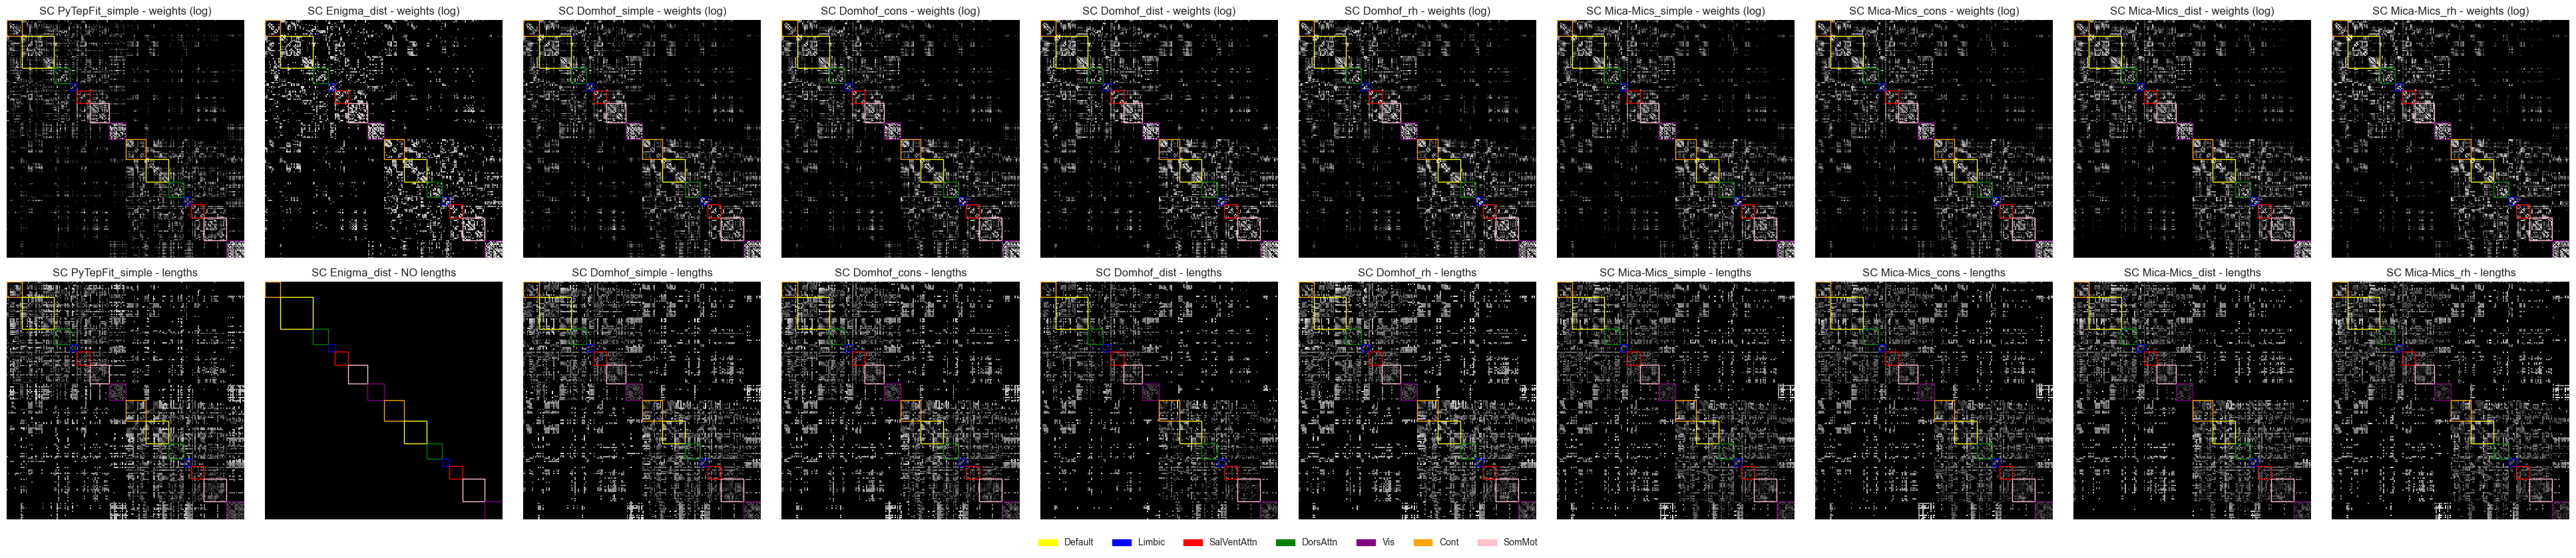

In [6]:
plotting.plot_structural_matrices_weight_lengths(SC_matrices,fig_dir,PARCELLATION)

Text(0.5, 1.0, 'ROI distances')

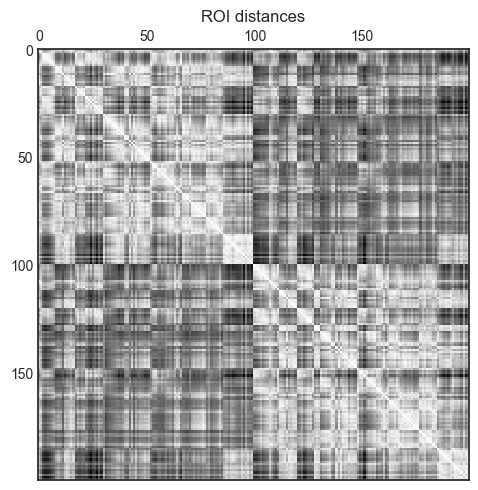

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(5,5),tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

## Compare structural connectivity matrices

In [8]:
plt.style.use('ggplot')

First, each matrix is turned into column in padnas dataframe, because we are interested in distribution of weights and edges no matter their position in the connectome.

In [9]:
dict_weights = dict()
dict_lengths = dict()

datasets_set = set()
prep_methods_set = set()

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    if len(name.split("_")) > 1:
        dataset,prep_method = name.split("_")
    else: 
        dataset = name
        prep_method = '-'

    datasets_set.add(dataset)
    prep_methods_set.add(prep_method)

    dict_weights[(dataset,prep_method)] = SC_W.flatten()
    
    if SC_L is not None:
        dict_lengths[(dataset,prep_method)] = SC_L.flatten()

df_weights = pd.DataFrame(dict_weights)
df_lengths = pd.DataFrame(dict_lengths)

df_weights

PyTepFit        Enigma    Domhof                                   \
        simple          dist    simple         cons      dist        rh   
0          0.0      0.000000     0.000     0.000000     0.000  0.000000   
1         29.0   1032.150739   829.870   829.870000   829.870  0.012408   
2          0.0      1.000000     0.000     0.000000     0.000  0.000000   
3          0.0      1.000000     0.000     0.000000     0.000  0.000000   
4          0.0      1.000000     0.000     0.000000     0.000  0.000000   
...        ...           ...       ...          ...       ...       ...   
39995     75.0      1.000000    88.975    89.422111     0.000  0.000000   
39996   6999.0  12600.603643  7261.270  7261.270000  7261.270  0.042226   
39997   1605.0   3141.953440  2644.255  2644.255000  2644.255  0.022501   
39998    251.0      1.000000   528.585   528.585000   528.585  0.003070   
39999      0.0      0.000000     0.000     0.000000     0.000  0.000000   

         Mica-Mics                                       
            simple          cons         dist        rh  
0          0.00000      0.000000      0.00000  0.000000  
1       2751.09720   2751.097200   2751.09720  0.011827  
2          0.00000      0.000000      0.00000  0.000000  
3          0.00000      0.000000      0.00000  0.000000  
4          0.00000      0.000000      0.00000  0.000000  
...            ...           ...          ...       ...  
39995    384.00178    391.838551      0.00000  0.000979  
39996  19633.42400  19633.424000  19633.42400  0.048011  
39997   7736.35320   7736.353200   7736.35320  0.027514  
39998   1628.49428   1628.494280   1628.49428  0.004204  
39999      0.00000      0.000000      0.00000  0.000000  

[40000 rows x 10 columns]

In [10]:
def select_df_by_dataset(df,dataset):
    return df.xs(dataset, level=0, axis=1)

def select_df_by_prep_method(df,method):
    return df.xs(method, level=1, axis=1)

def minmax_norm(column):
    return (column - column.min()) / (column.max() - column.min())

Create copy of the dataset with min-max normalized weights. This step is necessary because we wand to compare the datasets with each other and the weights are systematically different for some of them (for example averaged number of streamlines for simple averaging method and ratio of streamlines for Rosen and Halgren's method). 

In [11]:
columns = list(df_weights.columns)

df_weights_normalized = df_weights.copy()

for col in columns:
    df_weights_normalized[col] = minmax_norm(df_weights_normalized[col])
df_weights_normalized

PyTepFit    Enigma    Domhof                               Mica-Mics  \
         simple      dist    simple      cons      dist        rh    simple   
0      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.001427  0.014529  0.032562  0.032562  0.032562  0.072610  0.032943   
2      0.000000  0.000014  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.000014  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  0.000014  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
39995  0.003692  0.000014  0.003491  0.003509  0.000000  0.000000  0.004598   
39996  0.344507  0.177373  0.284918  0.284918  0.284918  0.247105  0.235098   
39997  0.079002  0.044228  0.103755  0.103755  0.103755  0.131676  0.092638   
39998  0.012355  0.000014  0.020741  0.020741  0.020741  0.017964  0.019500   
39999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                                     
           cons      dist        rh  
0      0.000000  0.000000  0.000000  
1      0.032943  0.032943  0.079785  
2      0.000000  0.000000  0.000000  
3      0.000000  0.000000  0.000000  
4      0.000000  0.000000  0.000000  
...         ...       ...       ...  
39995  0.004692  0.000000  0.006608  
39996  0.235098  0.235098  0.323882  
39997  0.092638  0.092638  0.185610  
39998  0.019500  0.019500  0.028359  
39999  0.000000  0.000000  0.000000  

[40000 rows x 10 columns]

Number of non-zero values:

In [12]:
df_weights.astype(bool).sum(axis=0)

PyTepFit   simple    10028
Enigma     dist      39784
Domhof     simple    10000
           cons      10000
           dist       6846
           rh        10000
Mica-Mics  simple    10000
           cons      10000
           dist      10000
           rh        10000
dtype: int64

Simple characteristics for each dataset and preprocessing method:

In [13]:
df_weights.describe().T

count        mean          std  min  25%  50%        75%  \
PyTepFit  simple  40000.0   94.787200   513.218128  0.0  0.0  0.0  25.000000   
Enigma    dist    40000.0  358.176876  2151.947796  0.0  1.0  1.0   1.000000   
Domhof    simple  40000.0  226.672494   996.973831  0.0  0.0  0.0  19.738750   
          cons    40000.0  226.893182   996.966325  0.0  0.0  0.0  20.378173   
          dist    40000.0  213.072168   998.071859  0.0  0.0  0.0   0.000000   
          rh      40000.0    0.002191     0.008905  0.0  0.0  0.0   0.000212   
Mica-Mics simple  40000.0  660.710718  2740.708025  0.0  0.0  0.0  60.323810   
          cons    40000.0  661.160136  2740.799081  0.0  0.0  0.0  60.737770   
          dist    40000.0  649.545294  2739.638157  0.0  0.0  0.0  43.203440   
          rh      40000.0    0.002214     0.008622  0.0  0.0  0.0   0.000221   

                           max  
PyTepFit  simple  20316.000000  
Enigma    dist    71040.115251  
Domhof    simple  25485.455000  
          cons    25485.455000  
          dist    25485.455000  
          rh          0.170881  
Mica-Mics simple  83511.500000  
          cons    83511.500000  
          dist    83511.500000  
          rh          0.148236

#### Correlations between structural connectivity matrices

We calculate and plot correlations between all the structural matrices. We want to see how much similar to each other are the structural connectivity weight matrices from different datasets and if they differ based on preprocessing method.

In [14]:
correlations = pg.pairwise_corr(df_weights,method="spearman")
correlations

X                    Y    method alternative      n  \
0    (PyTepFit, simple)       (Enigma, dist)  spearman   two-sided  40000   
1    (PyTepFit, simple)     (Domhof, simple)  spearman   two-sided  40000   
2    (PyTepFit, simple)       (Domhof, cons)  spearman   two-sided  40000   
3    (PyTepFit, simple)       (Domhof, dist)  spearman   two-sided  40000   
4    (PyTepFit, simple)         (Domhof, rh)  spearman   two-sided  40000   
5    (PyTepFit, simple)  (Mica-Mics, simple)  spearman   two-sided  40000   
6    (PyTepFit, simple)    (Mica-Mics, cons)  spearman   two-sided  40000   
7    (PyTepFit, simple)    (Mica-Mics, dist)  spearman   two-sided  40000   
8    (PyTepFit, simple)      (Mica-Mics, rh)  spearman   two-sided  40000   
9        (Enigma, dist)     (Domhof, simple)  spearman   two-sided  40000   
10       (Enigma, dist)       (Domhof, cons)  spearman   two-sided  40000   
11       (Enigma, dist)       (Domhof, dist)  spearman   two-sided  40000   
12       (Enigma, dist)         (Domhof, rh)  spearman   two-sided  40000   
13       (Enigma, dist)  (Mica-Mics, simple)  spearman   two-sided  40000   
14       (Enigma, dist)    (Mica-Mics, cons)  spearman   two-sided  40000   
15       (Enigma, dist)    (Mica-Mics, dist)  spearman   two-sided  40000   
16       (Enigma, dist)      (Mica-Mics, rh)  spearman   two-sided  40000   
17     (Domhof, simple)       (Domhof, cons)  spearman   two-sided  40000   
18     (Domhof, simple)       (Domhof, dist)  spearman   two-sided  40000   
19     (Domhof, simple)         (Domhof, rh)  spearman   two-sided  40000   
20     (Domhof, simple)  (Mica-Mics, simple)  spearman   two-sided  40000   
21     (Domhof, simple)    (Mica-Mics, cons)  spearman   two-sided  40000   
22     (Domhof, simple)    (Mica-Mics, dist)  spearman   two-sided  40000   
23     (Domhof, simple)      (Mica-Mics, rh)  spearman   two-sided  40000   
24       (Domhof, cons)       (Domhof, dist)  spearman   two-sided  40000   
25       (Domhof, cons)         (Domhof, rh)  spearman   two-sided  40000   
26       (Domhof, cons)  (Mica-Mics, simple)  spearman   two-sided  40000   
27       (Domhof, cons)    (Mica-Mics, cons)  spearman   two-sided  40000   
28       (Domhof, cons)    (Mica-Mics, dist)  spearman   two-sided  40000   
29       (Domhof, cons)      (Mica-Mics, rh)  spearman   two-sided  40000   
30       (Domhof, dist)         (Domhof, rh)  spearman   two-sided  40000   
31       (Domhof, dist)  (Mica-Mics, simple)  spearman   two-sided  40000   
32       (Domhof, dist)    (Mica-Mics, cons)  spearman   two-sided  40000   
33       (Domhof, dist)    (Mica-Mics, dist)  spearman   two-sided  40000   
34       (Domhof, dist)      (Mica-Mics, rh)  spearman   two-sided  40000   
35         (Domhof, rh)  (Mica-Mics, simple)  spearman   two-sided  40000   
36         (Domhof, rh)    (Mica-Mics, cons)  spearman   two-sided  40000   
37         (Domhof, rh)    (Mica-Mics, dist)  spearman   two-sided  40000   
38         (Domhof, rh)      (Mica-Mics, rh)  spearman   two-sided  40000   
39  (Mica-Mics, simple)    (Mica-Mics, cons)  spearman   two-sided  40000   
40  (Mica-Mics, simple)    (Mica-Mics, dist)  spearman   two-sided  40000   
41  (Mica-Mics, simple)      (Mica-Mics, rh)  spearman   two-sided  40000   
42    (Mica-Mics, cons)    (Mica-Mics, dist)  spearman   two-sided  40000   
43    (Mica-Mics, cons)      (Mica-Mics, rh)  spearman   two-sided  40000   
44    (Mica-Mics, dist)      (Mica-Mics, rh)  spearman   two-sided  40000   

           r         CI95%  p-unc  power  
0   0.579477  [0.57, 0.59]    0.0    1.0  
1   0.791775   [0.79, 0.8]    0.0    1.0  
2   0.791062  [0.79, 0.79]    0.0    1.0  
3   0.722952  [0.72, 0.73]    0.0    1.0  
4   0.770245  [0.77, 0.77]    0.0    1.0  
5   0.751952  [0.75, 0.76]    0.0    1.0  
6   0.751294  [0.75, 0.76]    0.0    1.0  
7   0.723998  [0.72, 0.73]    0.0    1.0  
8   0.736766  [0.73, 0.74]    0.0    1.0  
9   0.631736  [0.63, 0.64]    0.0    1.0  
10  0.

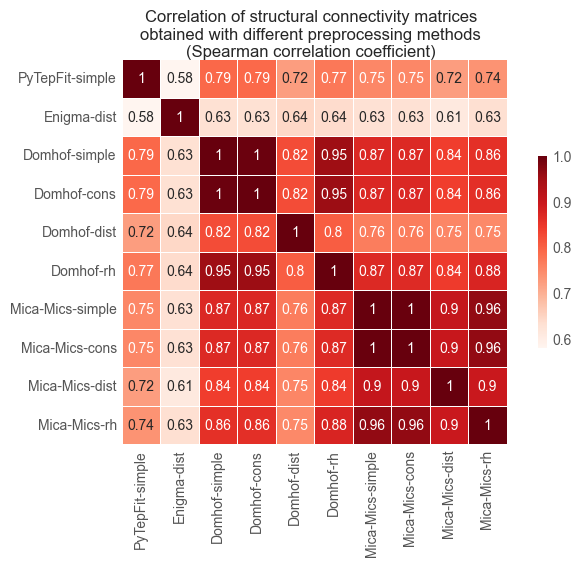

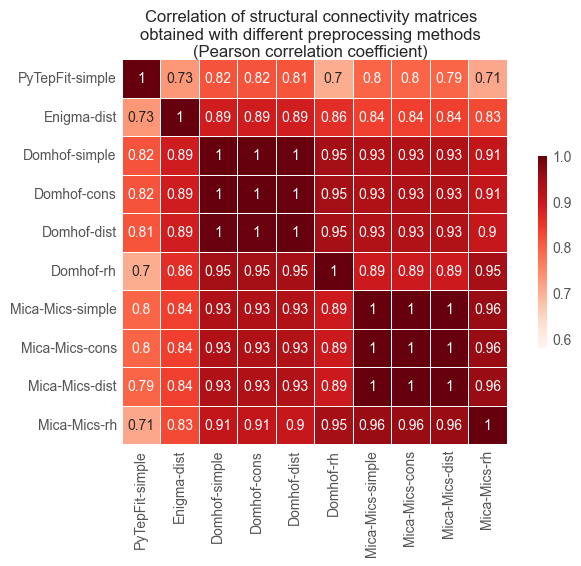

In [15]:
for corr_m in ['Spearman','Pearson']:
    plt.subplots(figsize=(8,5))
    ax = sns.heatmap(df_weights.corr(method=corr_m.lower()), cmap="Reds",vmax=1, vmin=min(correlations["r"]),
                square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
    ax.set(xlabel="", ylabel="")
    plt.suptitle(f"Correlation of structural connectivity matrices\nobtained with different preprocessing methods\n({corr_m} correlation coefficient)")
    plt.savefig(paths.path_figures(fig_dir+f"correlations_all_matrices_{corr_m}.pdf"),bbox_inches='tight',pad_inches=0)
    plt.show()


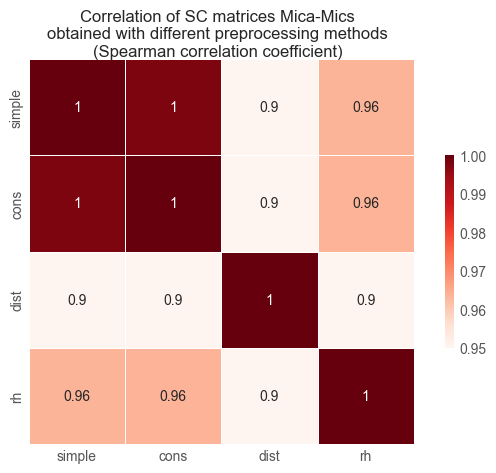

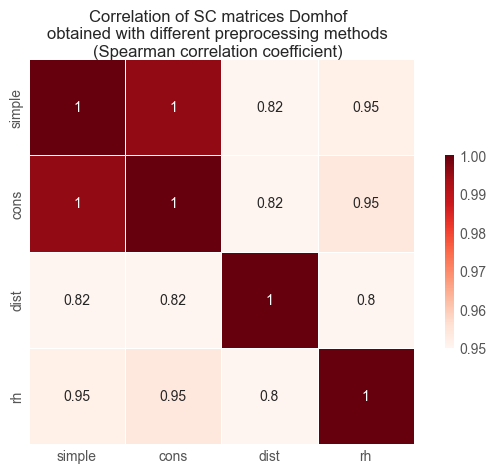

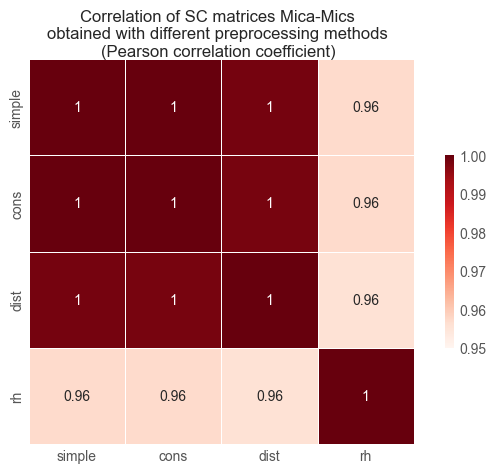

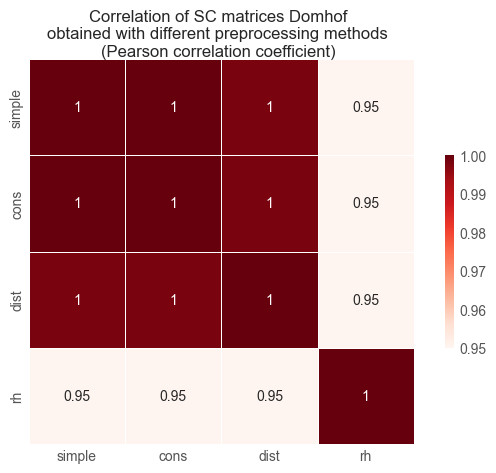

In [16]:
for corr_m in ['Spearman','Pearson']:
    for ds in ["Mica-Mics","Domhof"]:
        if ds not in datasets_set:
            continue
        plt.subplots(figsize=(8,5))
        df_filterd = select_df_by_dataset(df_weights,ds)
        ax = sns.heatmap(df_filterd.corr(method=corr_m.lower()), cmap="Reds",vmax=1, vmin=0.95,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
        ax.set(xlabel="", ylabel="")
        plt.suptitle(f"Correlation of SC matrices {ds}\nobtained with different preprocessing methods\n({corr_m} correlation coefficient)")
        plt.savefig(paths.path_figures(fig_dir+f"correlations_{ds}_{corr_m}.pdf"),bbox_inches='tight',pad_inches=0)
        plt.show()

### Distribution of weights in structural connectomes

All the connectomes are considered min-max normalized so the weights distributions are comparable accross datasets and preprocessing methods.

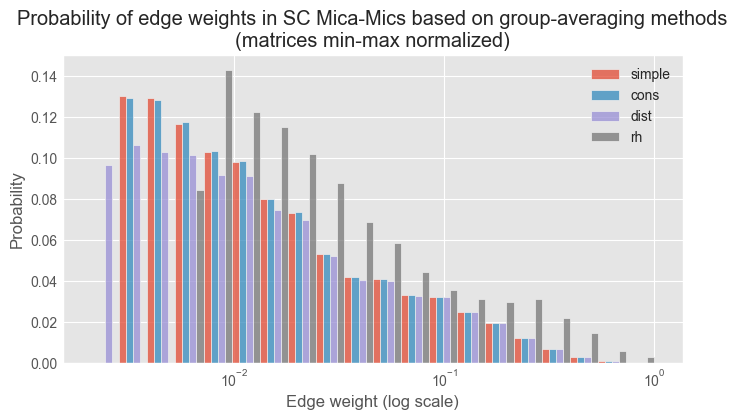

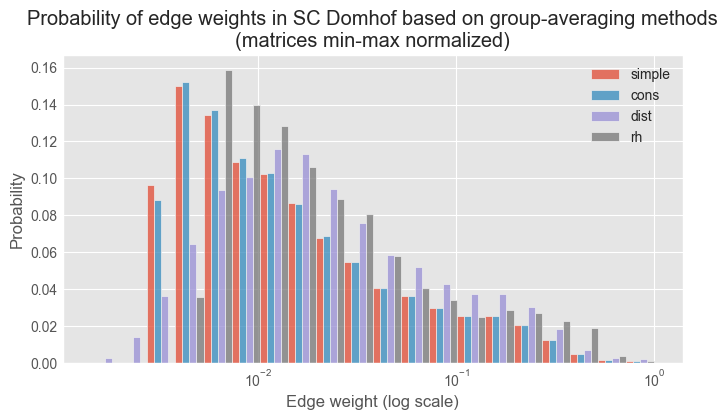

In [17]:
for ds in ["Mica-Mics","Domhof"]:
    if ds not in datasets_set:
        continue
    plt.subplots(figsize=(8,4))
    sns.histplot(select_df_by_dataset(df_weights_normalized,ds),bins=20,log_scale=True,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge weights in SC {ds} based on group-averaging methods\n(matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

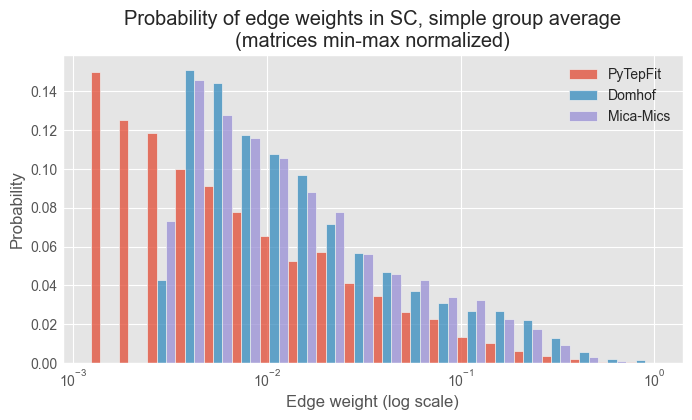

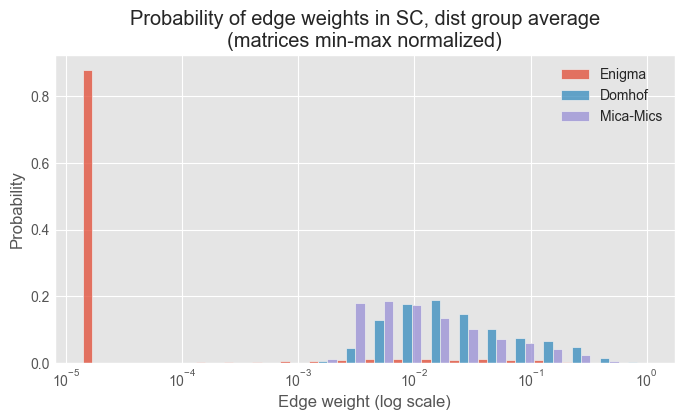

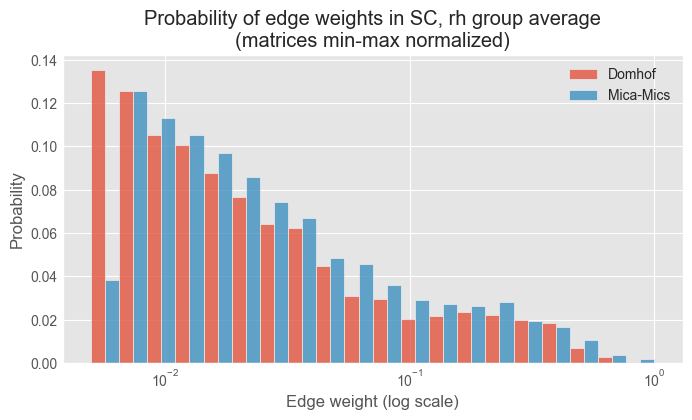

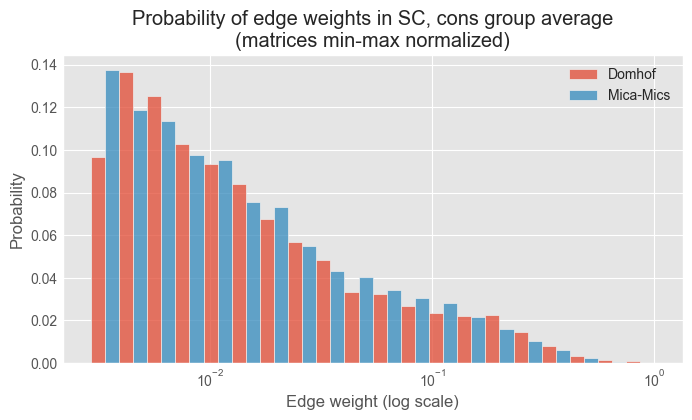

In [18]:
for m in ["simple","dist","rh","cons"]:
    if m not in prep_methods_set:
        continue
    plt.subplots(figsize=(8,4))
    sns.histplot(select_df_by_prep_method(df_weights_normalized,m),bins=20,log_scale=True,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge weights in SC, {m} group average\n(matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

### Distribution of lengths in structural connectomes

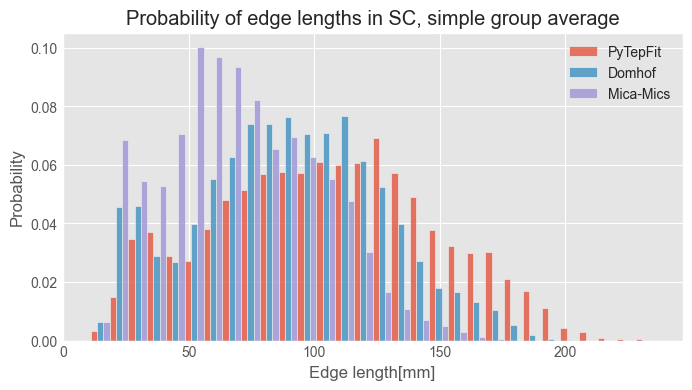

In [19]:
for m in ["simple"]:
    if m not in prep_methods_set:
        continue
    plt.subplots(figsize=(8,4))
    sns.histplot(select_df_by_prep_method(df_lengths,m),bins=30,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge length[mm]")
    title = f"Probability of edge lengths in SC, {m} group average"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()


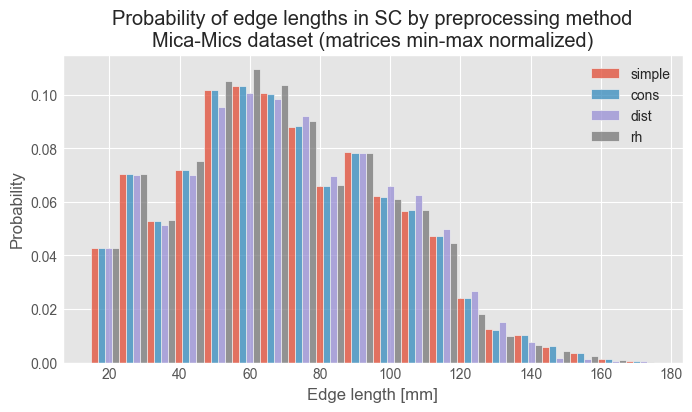

In [20]:
if PARCELLATION != "DKT":    
    plt.subplots(figsize=(8,4))
    sns.histplot(select_df_by_dataset(df_lengths,'Mica-Mics'),bins=20,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge length [mm]")
    title = f"Probability of edge lengths in SC by preprocessing method\nMica-Mics dataset (matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

### Connectomes in 3D space

We want to see how are the weights spatially distributed in the brain. They are again min-max normalized and log scaled, because we want to have the colorscale comparable accros the datasets and group averaging methods.

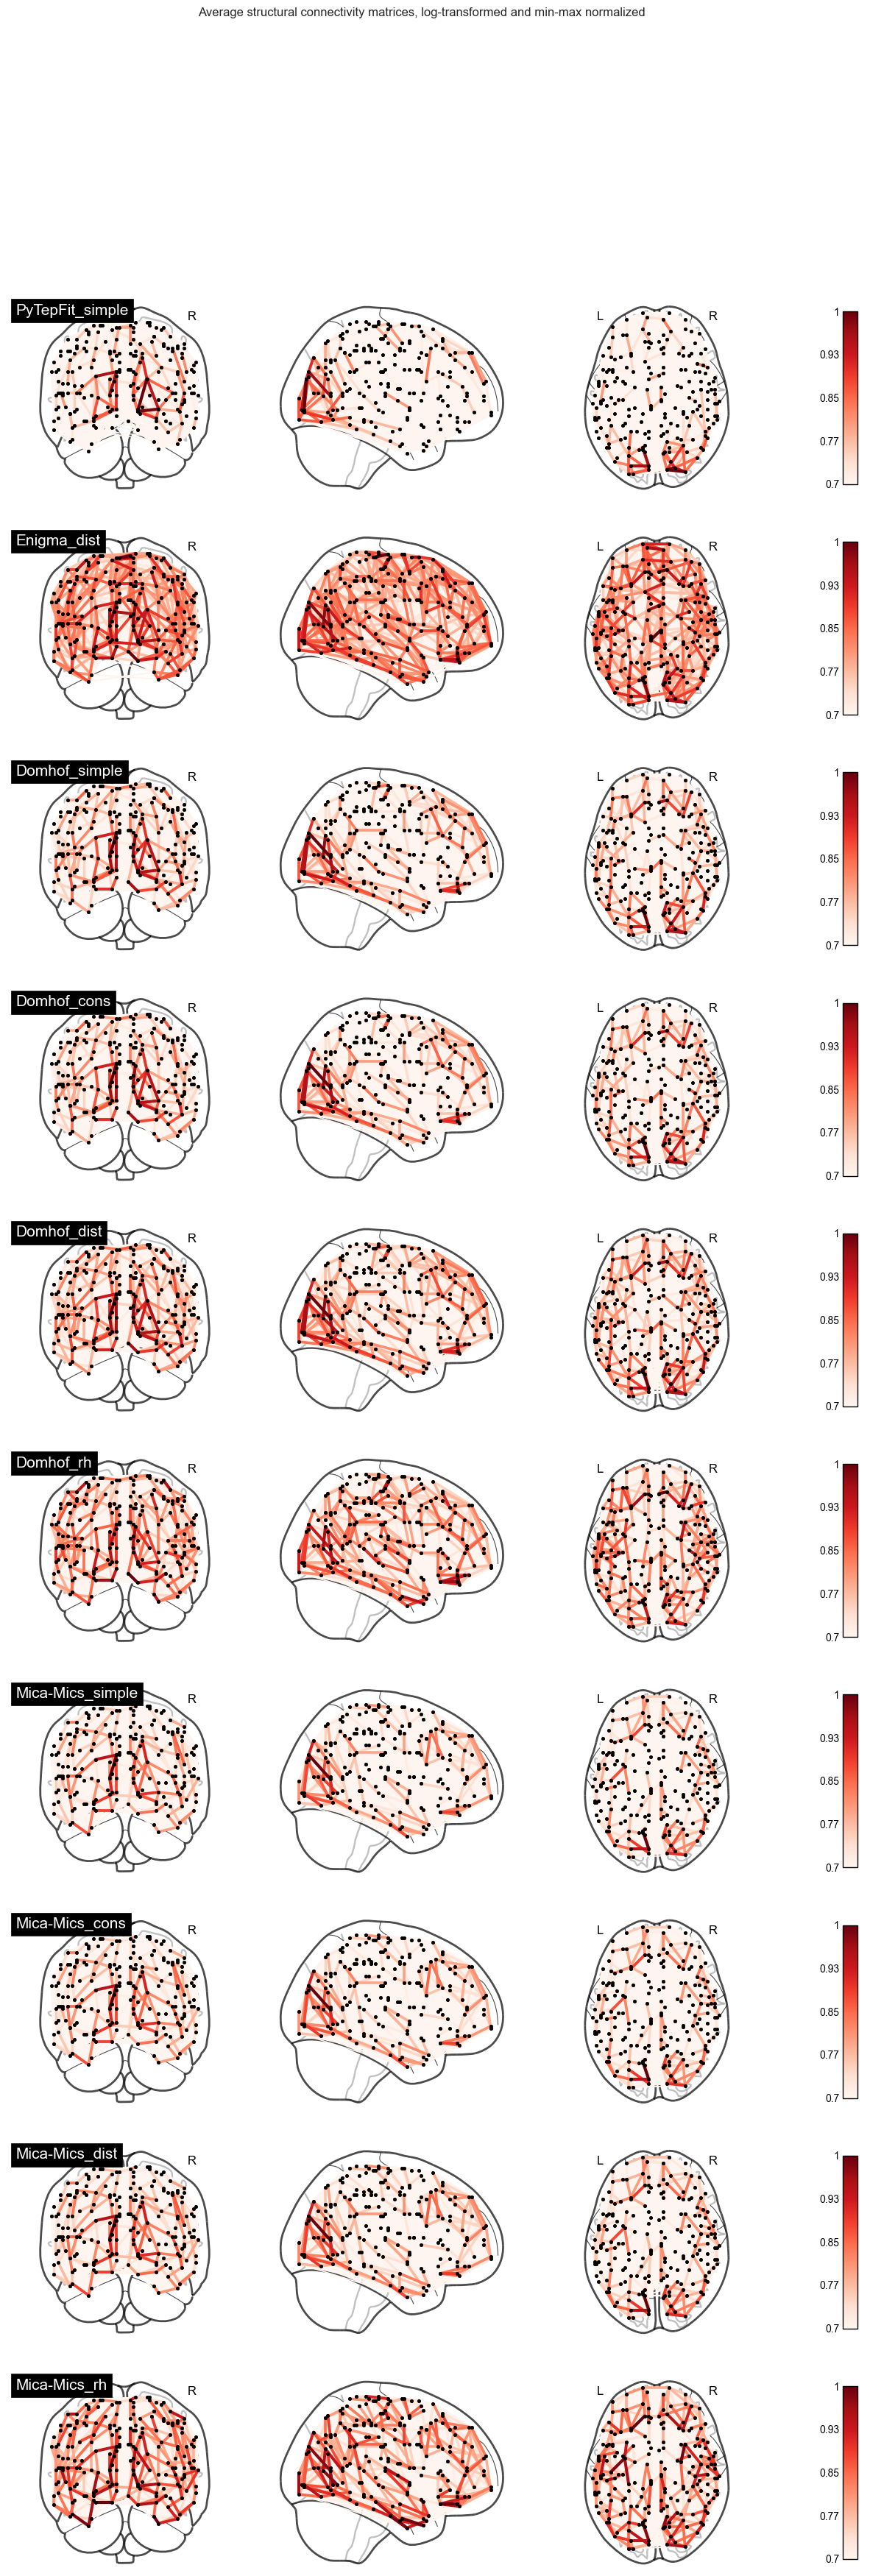

In [21]:
if centroid_coords is not None:
    # the coordinates are not in MNI space, so we shift them manually for plotting reasons
    for i in range(3):
        centroid_coords[:,i] = centroid_coords[:,i] - ((centroid_coords[:,i].max()-centroid_coords[:,i].min())/2+centroid_coords[:,i].min())
    centroid_coords[:,1]-=12
    centroid_coords[:,2]+=15

    fig, ax= plt.subplots(len(SC_matrices),1,figsize=(15,len(SC_matrices)*4),sharex=True,sharey=True)
    fig.suptitle(f"Average structural connectivity matrices, log-transformed and min-max normalized")

    for i,d in enumerate(SC_matrices):
        name, SC_W, _, SC_W_log = d
        m = np.nan_to_num(SC_W_log,nan=np.nan,posinf=np.nan,neginf=np.nan)

        # scale all values to <0,1> interval so the plots have comparable colors
        m = (m - np.nanmin(m,axis=None))
        m = m/np.nanmax(m,axis=None)
        np.fill_diagonal(m,0)

        niplotting.plot_connectome(m,centroid_coords,axes=ax[i],node_color="k",node_size=10,title=name,colorbar=True,edge_cmap='Reds',edge_vmin=0.7,edge_vmax=1)

    plt.savefig(paths.path_figures(fig_dir+"connectomes_brain.pdf"))